# Agreement Plots

In [58]:
from datetime import datetime as dt
import itertools

import cartopy.crs as ccrs
import cmocean.cm as cmo
import cool_maps.plot as cplt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

import ggs2.maps as maps
import ggs2.models as models
import ggs2.model_processing as mp
import ggs2.pathfinding as pf
import ggs2.util as util

%matplotlib inline

## Parameters

In [59]:
speed_limits = [0.5, 0.4, 0.3]
heading_limits = [90, 60, 45]

mission_name = "cod2cabo1"
date_dir = "2025_04_17"
date="2025041700"

model1 = models.CMEMS()
name1 = "CMEMS"

model2 = models.ESPC()
name2 = "ESPC"

model3 = models.RTOFS('east')
name3 = "RTOFS-east"

## Functions
### Helper Functions

In [60]:
def create_limit_matrix(speed_limits, heading_limits): 
    matrix = np.array(list(itertools.product(speed_limits, heading_limits)))
    matrix = [(x[0], x[1]) for x in matrix]
    return matrix

def calculate_heading(data: xr.Dataset) -> xr.Dataset:
    u = data.u
    v = data.v

    heading = (90 - np.degrees(np.arctan2(v, u))) % 360

    data = data.assign(heading=heading)

    return data

def calculate_cos_similarity(ds1, ds2):
    cos_similarity = np.cos(np.radians((ds1.heading - ds2.heading + 180) % 360 - 180))
    cos_similarity.attrs["models"] = f"{ds1.attrs['model_name']} & {ds2.attrs['model_name']}"
    return cos_similarity

### Masking Functions

In [61]:
def mask_bimodel_comparison(speed_diff, cosine_sim, speed_limit, heading_limit):
    mask = speed_diff.where(
        (speed_diff.magnitude >= -speed_limit) & # speed differences are within a certain range
        (speed_diff.magnitude <= speed_limit) & 
        (cosine_sim >= heading_limit) & # heading differences are within a certain range
        (cosine_sim <= 1), drop=True
    )
    mask.attrs["models"] = f"{speed_diff.attrs['models']}"
    return mask

def mask_trimodel_comparison(speed_diff_list, cosine_sim_list, speed_limit, heading_limit):
    mask = speed_diff_list[0].where(
        (speed_diff_list[0].magnitude >= -speed_limit) & # speed differences are within a certain range
        (speed_diff_list[0].magnitude <= speed_limit) &
        (speed_diff_list[1].magnitude >= -speed_limit) &
        (speed_diff_list[1].magnitude <= speed_limit) &
        (speed_diff_list[2].magnitude >= -speed_limit) &
        (speed_diff_list[2].magnitude <= speed_limit) &
        (cosine_sim_list[0] >= heading_limit) & # heading differences are within a certain range
        (cosine_sim_list[0] <= 1) &
        (cosine_sim_list[1] >= heading_limit) &
        (cosine_sim_list[1] <= 1) &
        (cosine_sim_list[2] >= heading_limit) &
        (cosine_sim_list[2] <= 1), drop=True
    )
    mask.attrs["models"] = "CMEMS, ESPC, RTOFS (East)"
    return mask

Load Data

In [62]:
mlist = [model1, model2, model3]
nlist = [name1, name2, name3]
olist = []

# load data
for n, m in zip(nlist, mlist):
    dpath = f"products/{date_dir}/data/{mission_name}_{date}_{n}_dac.nc"
    d = xr.open_dataset(dpath)
    m.da_data = d
    m.da_data = calculate_heading(m.da_data)

    opath = f"products/{date_dir}/data/{mission_name}_{date}_{n}_mission_path.csv"
    o = pd.read_csv(opath).squeeze().to_dict()
    olist.append(o)

Get difference data

In [63]:
model_combinations = list(itertools.combinations(mlist, 2))

speed_diff_list = []
cosine_sim_list = []

for c in model_combinations:
    speed_diff = mp.calculate_simple_diff(c[0], c[1], diag_text=False)
    cosine_sim = calculate_cos_similarity(c[0].da_data, c[1].da_data)
    speed_diff.attrs["models"] = f"{c[0].name} & {c[1].name}"
    cosine_sim.attrs["models"] = f"{c[0].name} & {c[1].name}"
    speed_diff_list.append(speed_diff)
    cosine_sim_list.append(cosine_sim)

Create Limit Matrix

In [64]:
cosine_sim_limits = np.cos(np.radians(heading_limits))
limit_matrix = create_limit_matrix(speed_limits, cosine_sim_limits)

## Agreement Plots

In [65]:
extent = (
    float(model1.da_data.lat.min().values),
    float(model1.da_data.lon.min().values),
    float(model1.da_data.lat.max().values),
    float(model1.da_data.lon.max().values),
)

In [66]:
def plot_agreement(
        speed_diff_list: list[xr.Dataset], 
        cosine_sim_list: list[xr.DataArray], 
        limits: tuple[float, float], 
        extent: list[float],
        fig: plt.Figure = None,
        ax: plt.Axes = None, 
        proj: ccrs.Projection = ccrs.Mercator(),
        colors: tuple[str, str] = ("lightgray", "green"),
        i: int = None
    ) -> tuple[plt.Figure, plt.Axes]:
    # check if ax is provided. If not, create one
    if ax is None or fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={"projection":proj})
    
    # set theme and colors
    sns.set_theme(context="poster", palette="colorblind")
    gray = ListedColormap(colors[0])
    green = ListedColormap(colors[1])

    # extract speed and heading limits
    speed_limit, cs_limit = limits
    heading_limit = np.round(np.degrees(np.arccos(cs_limit)), 1)

    cplt.create(extent=[extent[1], extent[3], extent[0], extent[2]], gridlines=True, ax=ax, proj=proj, oceancolor="none")
    if i is None:
        title = f"±{speed_limit} $\mathregular{{ms^{{-1}}}}$, ±{heading_limit}°"
    else:
        title = f"{i}: ±{speed_limit} $\mathregular{{ms^{{-1}}}}$, ±{heading_limit}°"
    ax.set_title(title, y=1.03)

    # bimodel agreement
    for speed_diff, cosine_sim in zip(speed_diff_list, cosine_sim_list):
        bimodel_mask = mask_bimodel_comparison(speed_diff, cosine_sim, speed_limit, cs_limit)
        lon2D, lat2D = np.meshgrid(bimodel_mask.lon, bimodel_mask.lat)
        levels = np.linspace(bimodel_mask.magnitude.min(), bimodel_mask.magnitude.max(), 2)
        bimodel_cf = ax.contourf(lon2D, lat2D, bimodel_mask.magnitude, levels=levels, cmap=gray, transform=ccrs.PlateCarree())
        bimodel_cf.set_alpha(0.4)
    
    # trimodel agreement
    trimodel_mask = mask_trimodel_comparison(speed_diff_list, cosine_sim_list, speed_limit, cs_limit)
    lon2D, lat2D = np.meshgrid(trimodel_mask.lon, trimodel_mask.lat)
    levels = np.linspace(trimodel_mask.magnitude.min(), trimodel_mask.magnitude.max(), 2)
    trimodel_cf = ax.contourf(lon2D, lat2D, trimodel_mask.magnitude, levels=levels, cmap=green, transform=ccrs.PlateCarree())

    return fig, ax

def single_agreement_plot(
        speed_diff_list: list[xr.Dataset], 
        cosine_sim_list: list[xr.DataArray], 
        limits: tuple[float, float], 
        extent: list[float]
    ) -> plt.Figure:
    pal = sns.color_palette("colorblind")
    pal_hex = pal.as_hex()
    gray = pal_hex[7]
    green = pal_hex[2]
    
    fig, ax = plot_agreement(speed_diff_list, cosine_sim_list, limits, extent, colors=(gray, green))
    patches = []
    patches.append(mpatches.Patch(color=gray, alpha=0.4, label="Bi-Model Agreement"))
    patches.append(mpatches.Patch(color=green, label="Tri-Model Agreement"))
    legend = fig.legend(handles=patches, loc="lower center", frameon=False, ncol=5)

    return fig

def agreement_matrix(
        speed_diff_list: list[xr.Dataset], 
        cosine_sim_list: list[xr.DataArray], 
        limit_matrix: list[tuple[float, float]], 
        extent: list[float]
    ) -> plt.Figure:
    # set theme and colors
    sns.set_context("poster")
    pal = sns.color_palette("colorblind")
    pal_hex = pal.as_hex()
    gray = pal_hex[7]
    green = pal_hex[2]
    
    # plot
    fig, axes = plt.subplots(3, 3, figsize=(20, 14), subplot_kw={"projection":ccrs.Mercator()})
    for i, (ax, limits) in enumerate(zip(axes.flatten(), limit_matrix)):
        plot_agreement(speed_diff_list, cosine_sim_list, limits, extent, fig=fig, ax=ax, colors=(gray, green), i=i)
        patches = []
        patches.append(mpatches.Patch(color=gray, alpha=0.4, label="Bi-Model Agreement"))
        patches.append(mpatches.Patch(color=green, label="Tri-Model Agreement"))
        legend = fig.legend(handles=patches, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.05), ncol=5)
        
    plt.tight_layout()

    return fig

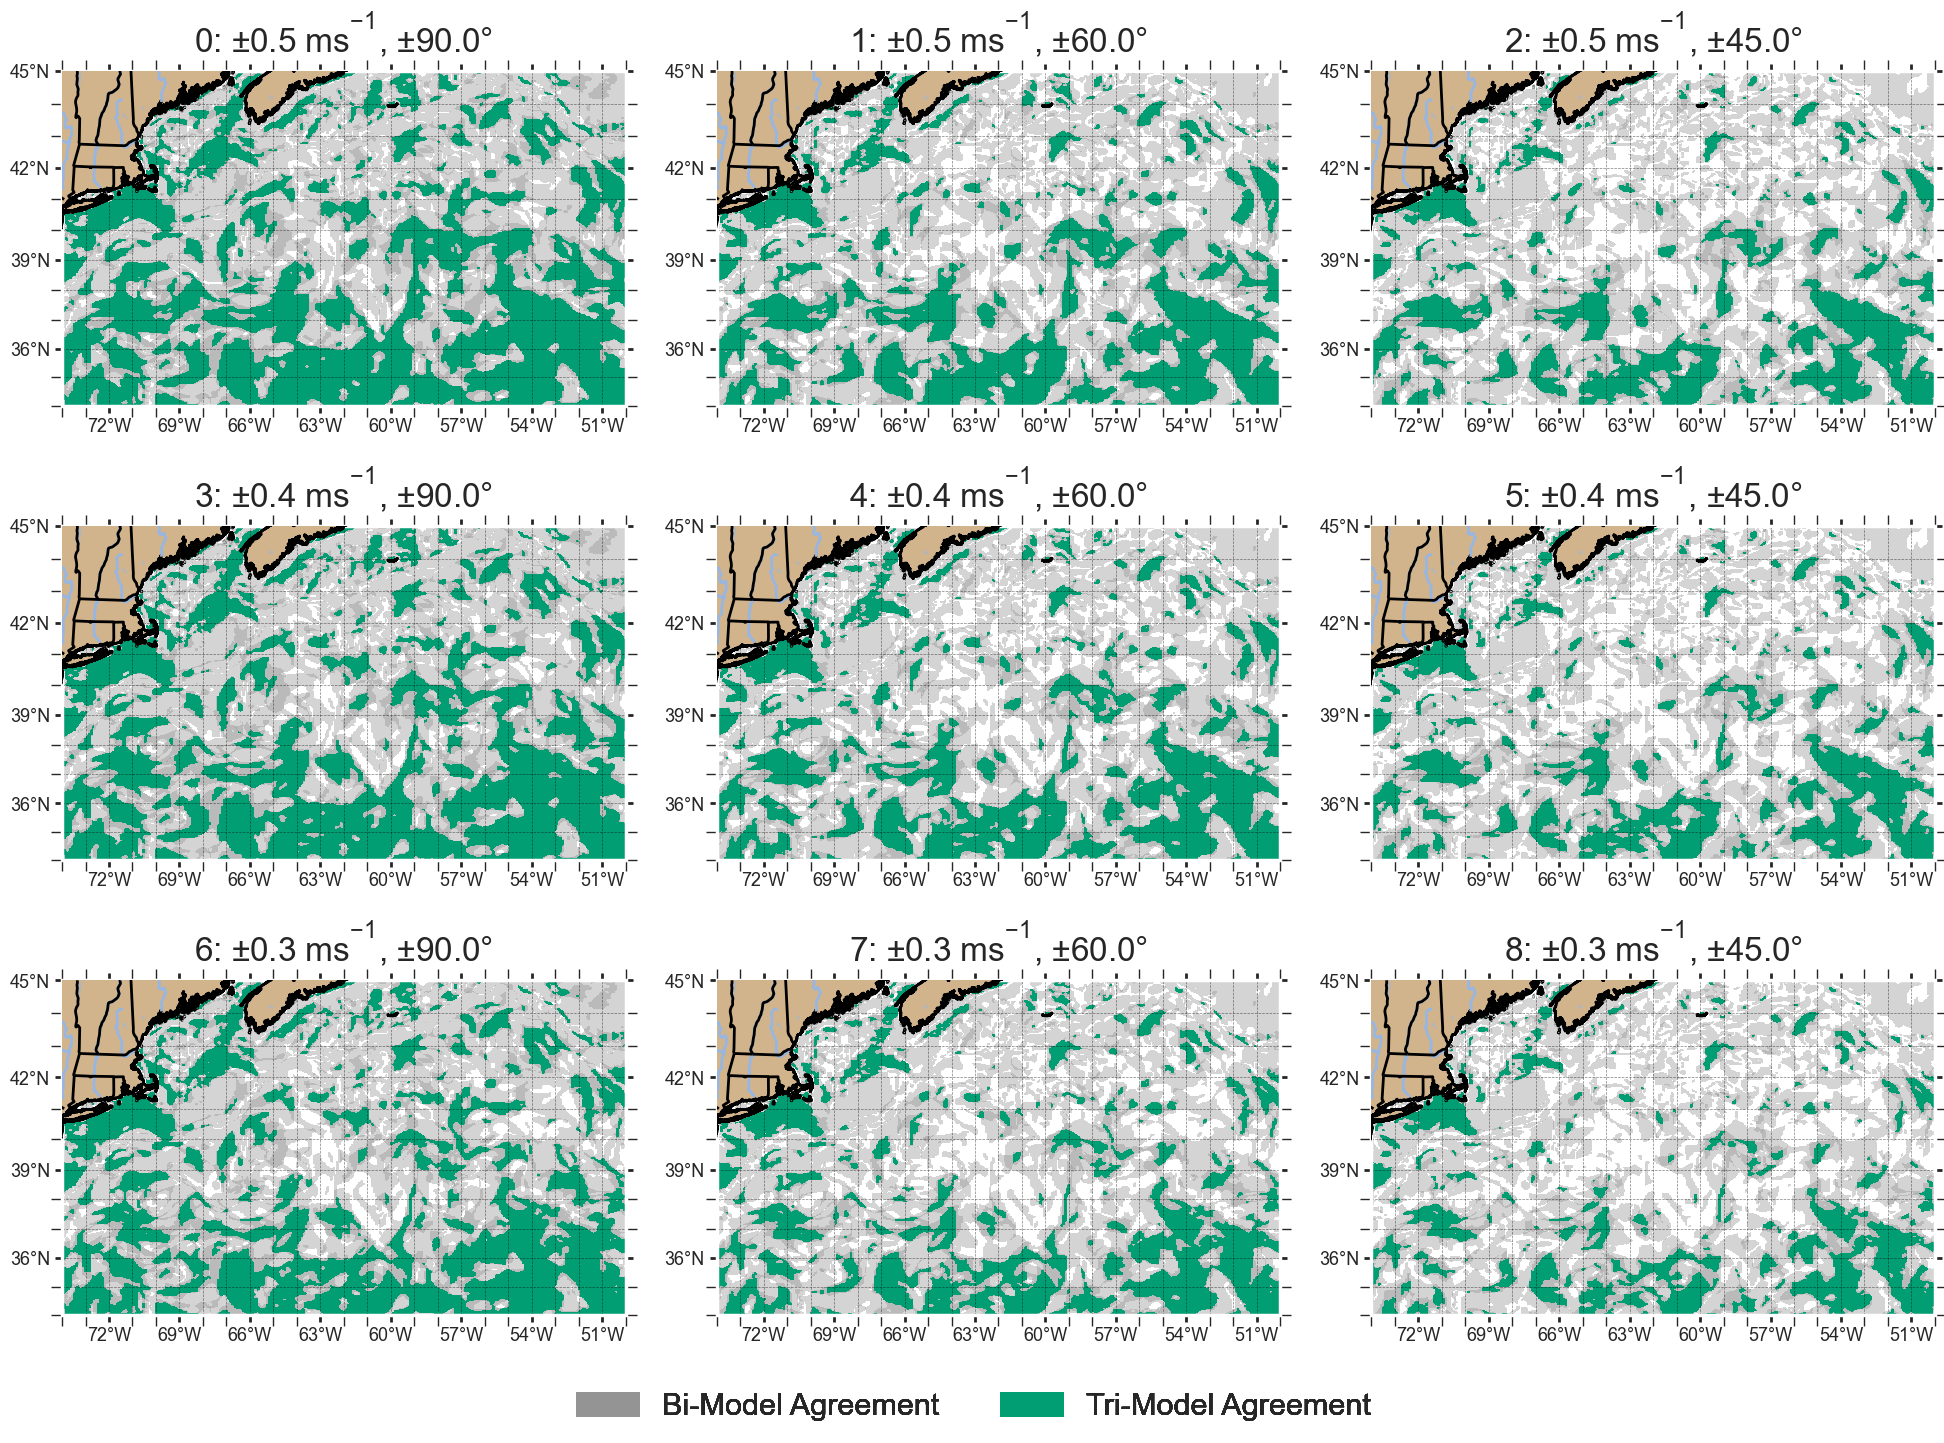

In [ ]:
matrixfig = agreement_matrix(speed_diff_list, cosine_sim_list, limit_matrix, extent)
plt.savefig(f"products/{date_dir}/matrixfig.png", dpi=600, bbox_inches="tight")

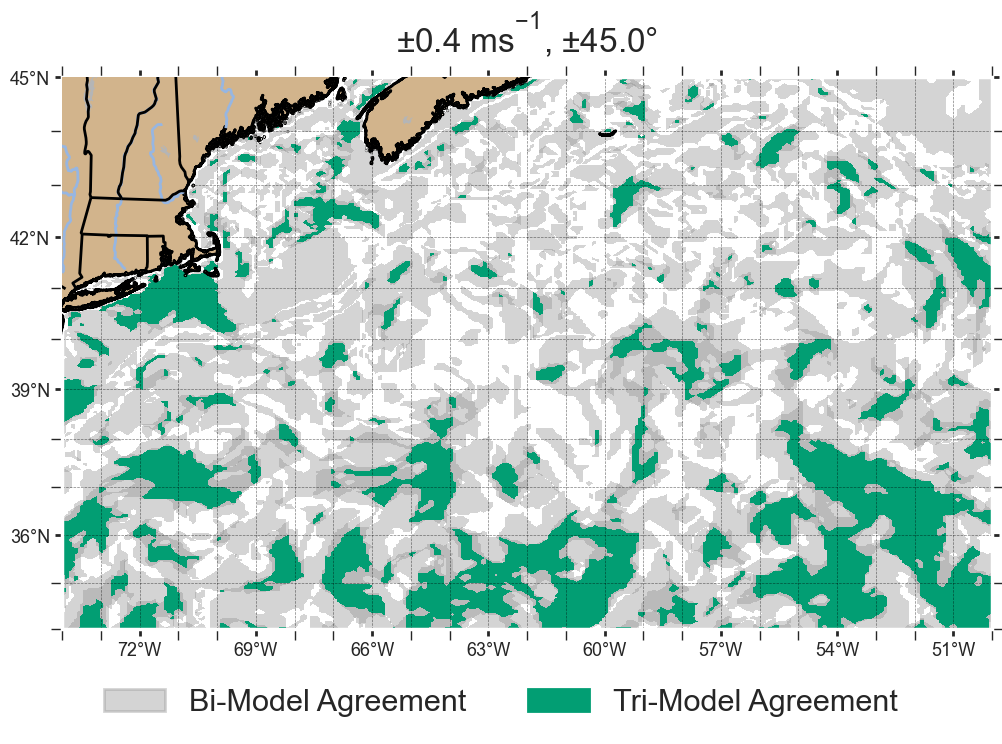

In [68]:
fig_number = 5
onefig = single_agreement_plot(speed_diff_list, cosine_sim_list, limit_matrix[fig_number], extent)
plt.savefig("onefig.png", dpi=600, bbox_inches="tight")

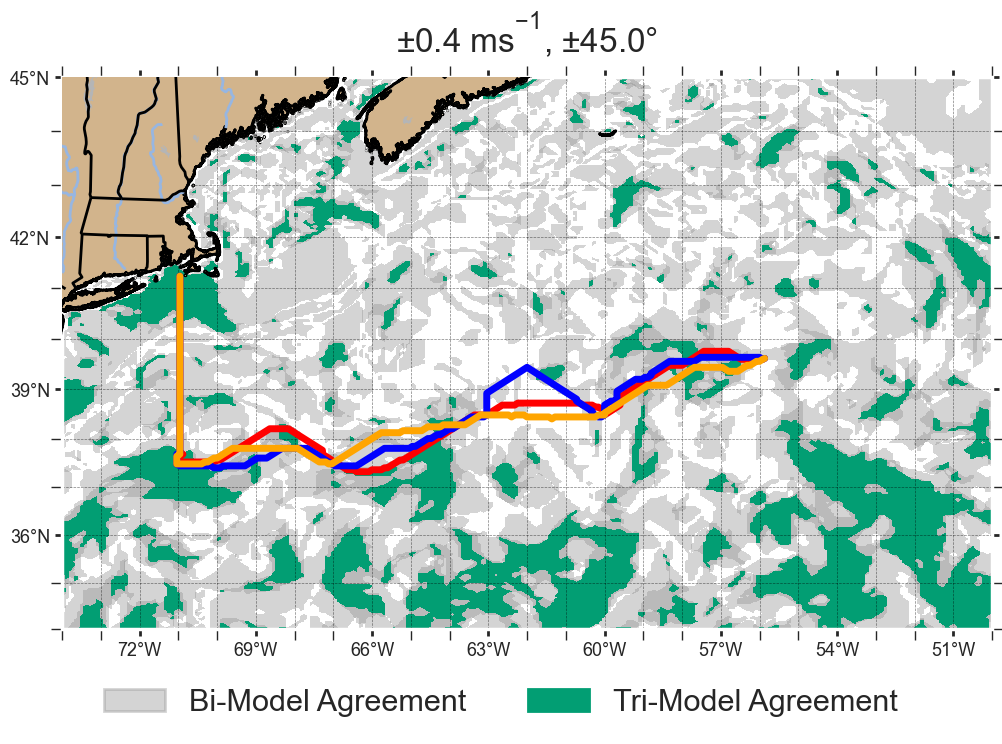

In [69]:
onefig_ax = onefig.get_axes()[0]
colors = ["red", "blue", "orange"]
names = ["CMEMS", "ESPC", "RTOFS"]
for i, o in enumerate(olist):
    lons = list(o['lon'].values())
    lats = list(o['lat'].values())
    cmems_path = onefig_ax.plot(lons, lats, linestyle='-', color=colors[i], linewidth=5, transform=ccrs.Geodetic(), label=names[i])
onefig

In [70]:
lons = list(olist[0]['lon'].values())
lats = list(olist[0]['lat'].values())

In [71]:
lons = []
for i in range(len(olist[0]["lon"])):
    lons.append(olist[0]["lon"][i])

In [72]:
len(olist[0])

2

NameError: name 'cplt_extent' is not defined

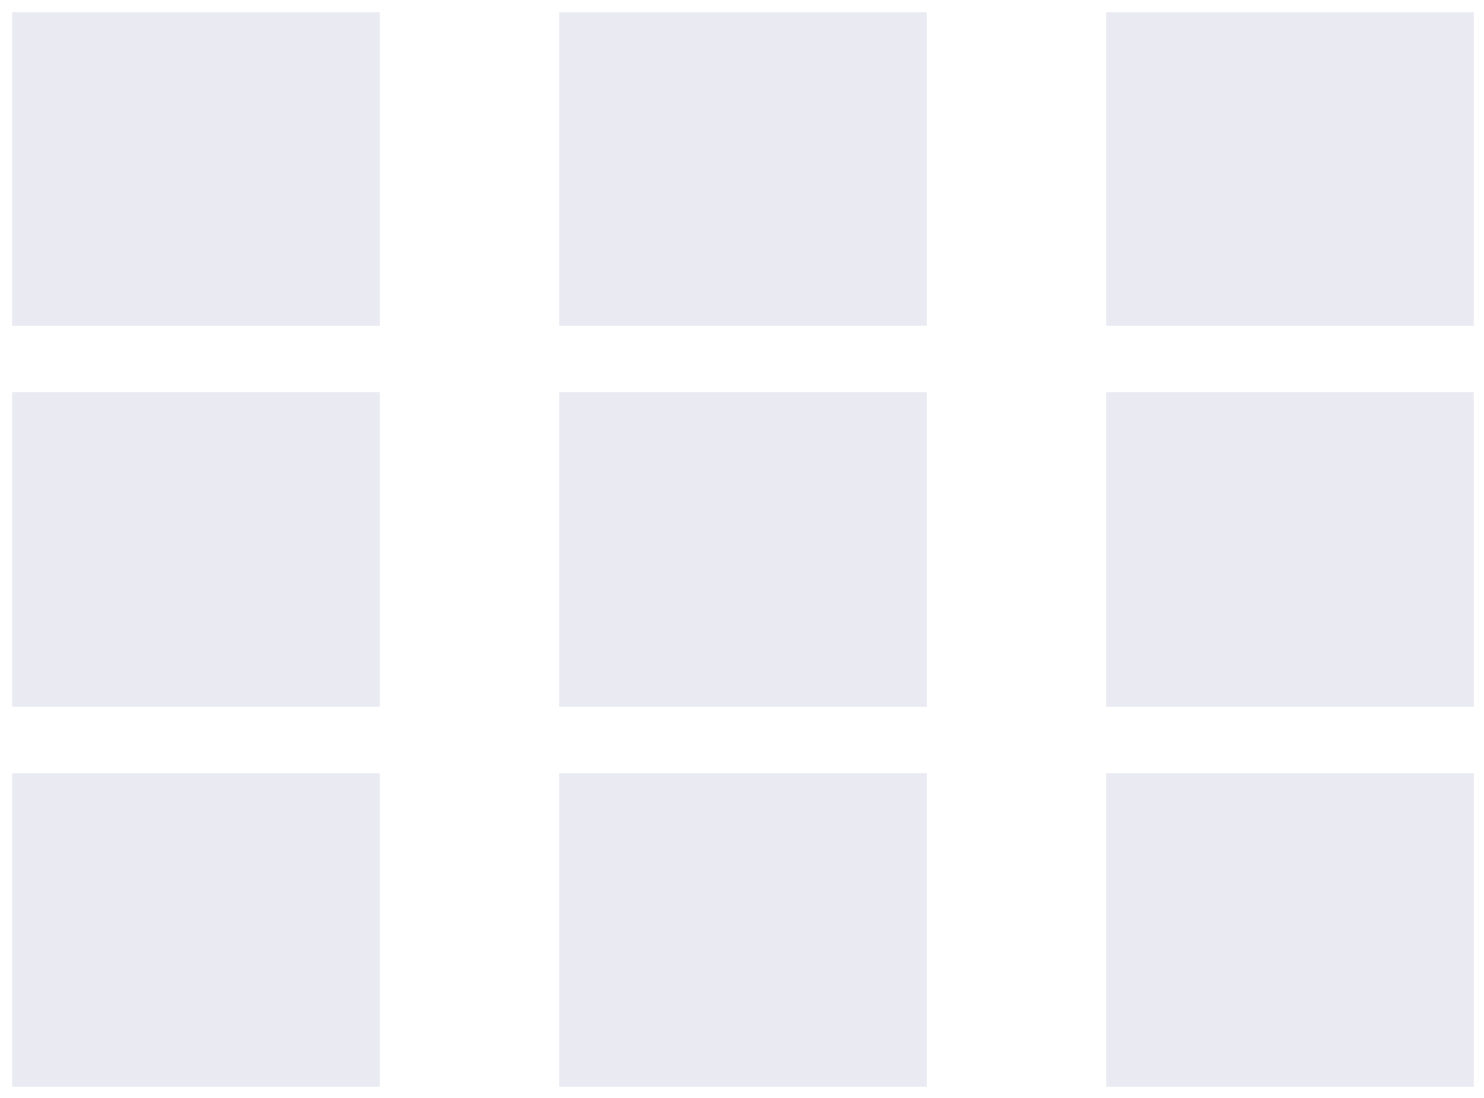

In [73]:
import matplotlib.lines as mlines

cosine_sim_limits = np.cos(np.radians(heading_limits))
limit_matrix = create_limit_matrix(speed_limits, cosine_sim_limits)

sns.set_theme(context="poster", palette="colorblind")
pal = sns.color_palette("colorblind")
pal_hex = pal.as_hex()
green = pal_hex[2]
gray = pal_hex[7]

fig, axes = plt.subplots(3, 3, figsize=(20, 14), subplot_kw={"projection":ccrs.Mercator()})

for ax, l in zip(axes.flatten(), limit_matrix):
    hl = np.round(np.degrees(np.arccos(l[1])), 1)

    # create basemap
    cplt.create(cplt_extent, gridlines=True, ax=ax, proj=ccrs.Mercator(), oceancolor="none")
    ax.set_title(f"±{l[0]} $\mathregular{{ms^{{-1}}}}$, ±{hl}°", y=1.03)

    # map bimodel agreement
    for speed_diff, cosine_sim in zip(speed_diff_list, cosine_sim_list):
        bimodel_mask = mask_bimodel_comparison(speed_diff, cosine_sim, l[0], l[1])
        lon2D, lat2D = np.meshgrid(bimodel_mask.lon, bimodel_mask.lat)
        levels = np.linspace(bimodel_mask.magnitude.min(), bimodel_mask.magnitude.max(), 2)
        cmap = ListedColormap(gray)
        bimodel_cf = ax.contourf(lon2D, lat2D, bimodel_mask.magnitude, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
        bimodel_cf.set_alpha(0.4)
    
    # map trimodel agreement
    trimodel_mask = mask_trimodel_comparison(speed_diff_list, cosine_sim_list, l[0], l[1])
    lon2D, lat2D = np.meshgrid(trimodel_mask.lon, trimodel_mask.lat)
    levels = np.linspace(trimodel_mask.magnitude.min(), trimodel_mask.magnitude.max(), 2)
    cmap = ListedColormap(green)
    trimodel_cf = ax.contourf(lon2D, lat2D, trimodel_mask.magnitude, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

    # # map each optimized track
    # color_list = ["red", "orange", "blue"]
    # for i in range(len(olist)):
    #     lats = [olist[i]['lat'][j] for j in range(len(olist[i]['lat']))]
    #     lons = [olist[i]['lon'][j] for j in range(len(olist[i]['lon']))]
    #     ax.plot(lons, lats, linestyle='-', color="white", linewidth=5, transform=ccrs.Geodetic())
    #     ax.plot(lons, lats, linestyle='-', color=color_list[i], linewidth=3, transform=ccrs.Geodetic())

patches = []
patches.append(mpatches.Patch(color=gray, alpha=0.4, label="Bi-Model Agreement"))
patches.append(mpatches.Patch(color=green, label="Tri-Model Agreement"))
# for i in range(len(olist)):
#     patches.append(mlines.Line2D([],[],color=color_list[i], label=nlist[i]))

legend = fig.legend(handles=patches, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.05), ncol=5)

# fig.suptitle("Depth Averaged Current Agreement Matrix (CMEMS, ESPC, RTOFS)", y=0.96)
plt.tight_layout()

fig.savefig("agreement_matrix_poster.png", dpi=600, bbox_inches="tight")

experimental with hatches. need to figure out how to get it to work because it looks great when it works

In [ ]:
# def map_agreement(data_list: list[xr.Dataset], projection: ccrs = ccrs.PlateCarree()):
#     # Basemap
#     fig, ax = init_basemap(cplt_extent=cplt_extent, projection=projection)

#     # Set up loops
#     patches = []
#     color_list = ["C0", "C1", "C4", "lime"]
#     hatch_list = ['////', '\\\\', '----', None]

#     for data, color, hatch in zip(data_list, color_list, hatch_list):
#         levels = np.linspace(data.magnitude.min(), data.magnitude.max(), 2)
#         lon2D, lat2D = np.meshgrid(data.lon, data.lat)
#         im = ax.contourf(lon2D, lat2D, data.magnitude, levels=levels)

#         for level_segs in im.allsegs:
#             for seg in level_segs:
#                 if len(seg) > 0:  # Ignore very small polygons (likely holes)
#                     if hatch:
#                         poly = mpatches.Polygon(seg, facecolor='none', edgecolor=color, hatch=hatch)
#                     else:
#                         poly = mpatches.Polygon(seg, facecolor=color, edgecolor="none")
#                     ax.add_patch(poly)

#         im.remove()
        
#         patches.append(mpatches.Patch(color=color, label=data.attrs["text_name"]))

#     ax.legend(handles=patches, loc="upper right", fontsize=14)

#     # Title
#     title = f"Agreement Overlap of {total_agreement.attrs['models']} (+/- {speed_limit}m/s), (+/- {heading_limit}cos similarity)"
#     plt.title(title)

#     plt.show()

# data_list = [combo_12_agreement, combo_13_agreement, combo_23_agreement, total_agreement]
# map_agreement(data_list)

## Agreement Thresholds
show areas of speed/heading agreement of increasing agreement

In [ ]:
simple_diff_12_masked = simple_diff_12.where((simple_diff_12.magnitude >= -0.5) & (simple_diff_12.magnitude <= 0.5), drop=True)
simple_diff_12_masked_abs = simple_diff_12_masked.copy()
simple_diff_12_masked_abs["magnitude"] = np.abs(simple_diff_12_masked.magnitude)

NameError: name 'simple_diff_12' is not defined

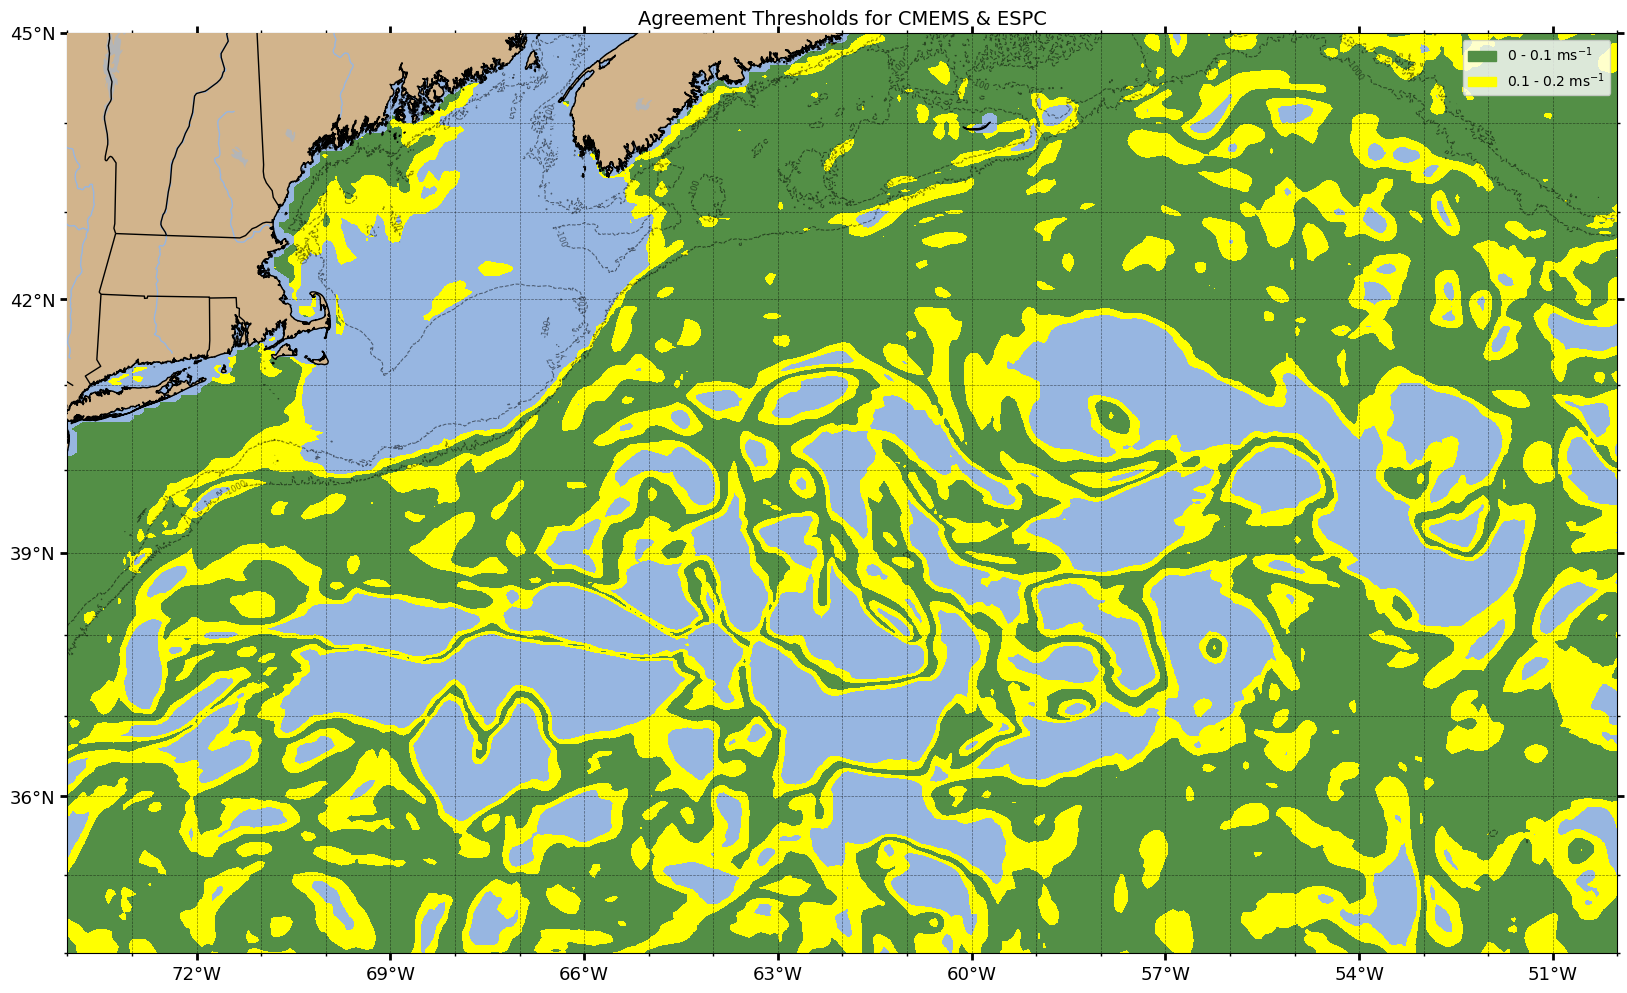

In [ ]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection": ccrs.Mercator()})
cplt.create(cplt_extent, gridlines=True, ax=ax, proj=ccrs.Mercator(), bathymetry=True)

# Define agreement thresholds and colors
mags = [0, 0.1, 0.2]
colors = ["#538f46", "yellow"]  # Corresponding colors for each range

# Ensure max_diff is properly considered
max_diff = np.nanmax(simple_diff_12_masked_abs.magnitude)

# Create a colormap with BoundaryNorm for proper level-color mapping
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(mags, cmap.N)  # Ensures correct color assignment

# Plot the agreement regions using contourf
contourf = ax.contourf(
    simple_diff_12_masked_abs.lon,
    simple_diff_12_masked_abs.lat,
    simple_diff_12_masked_abs.magnitude,
    levels=mags,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
)

# Create a legend
patches = [
    mpatches.Patch(color=colors[i], label=rf"{mags[i]} - {mags[i+1]} $\mathregular{{ms^{{-1}}}}$")
    for i in range(len(colors))
]

legend = ax.legend(handles=patches)
legend.set_zorder(100)

plt.title(f"Agreement Thresholds for {simple_diff_12.attrs['models']}", fontsize=14);

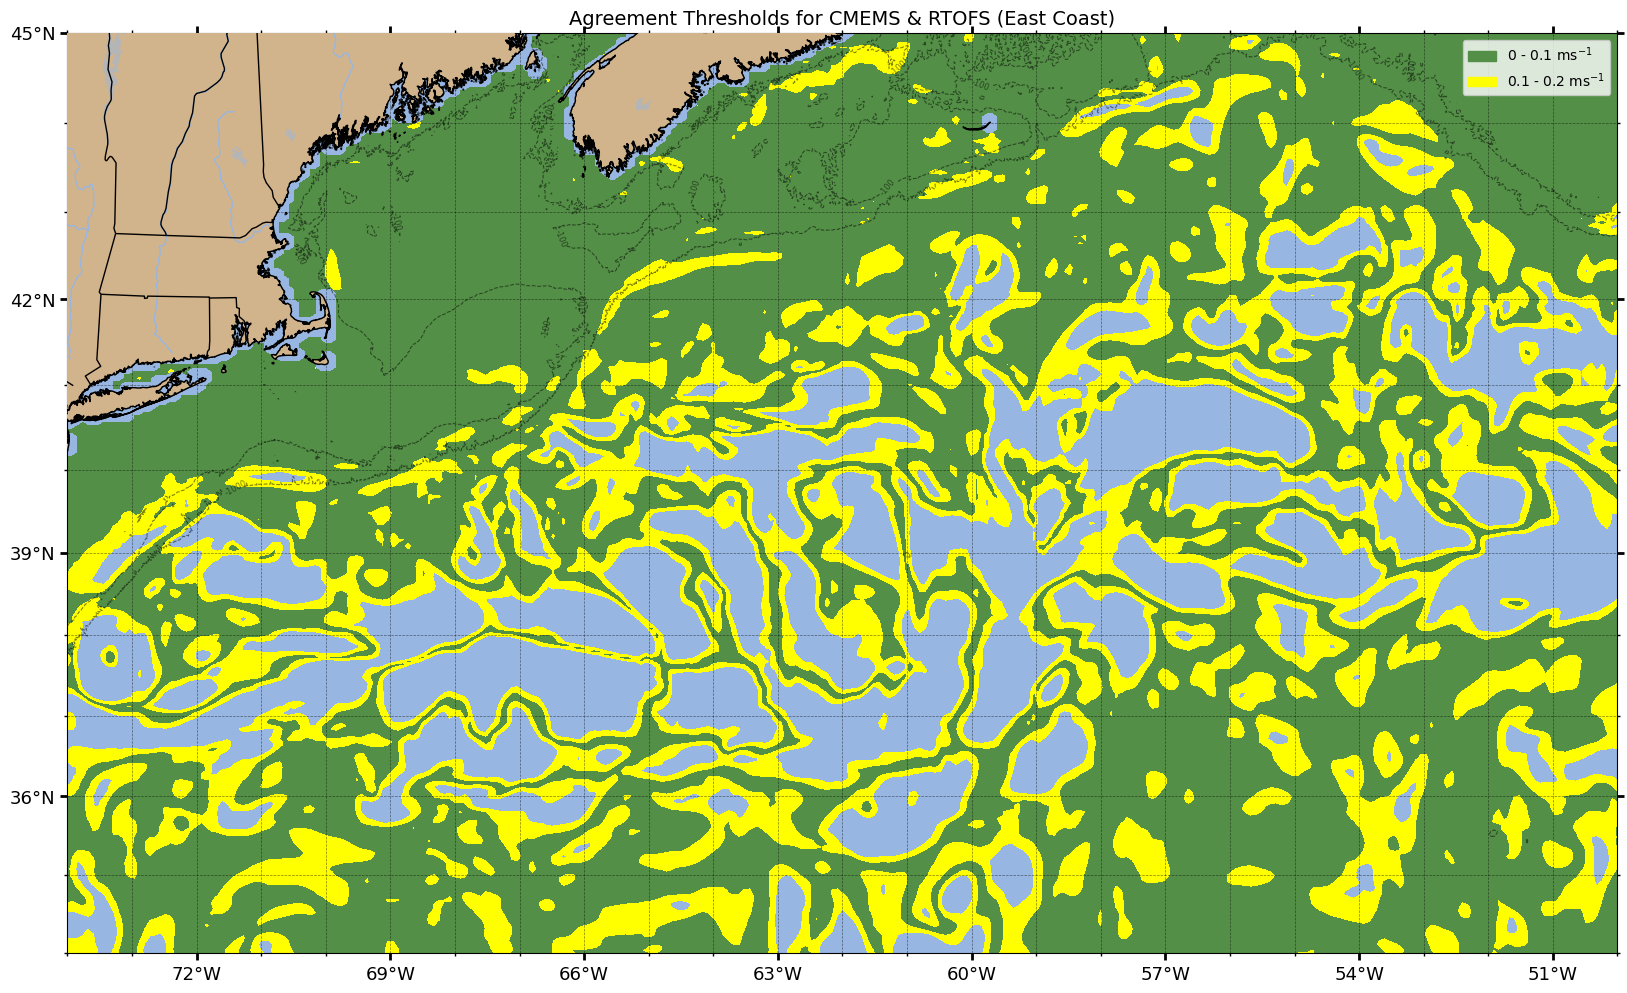

In [ ]:
import matplotlib.colors as mcolors

abs_diff = np.abs(simple_diff_13.magnitude)
abs_diff.attrs["models"] = simple_diff_13.attrs["models"]

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection": ccrs.Mercator()})
cplt.create(cplt_extent, gridlines=True, ax=ax, proj=ccrs.Mercator(), bathymetry=True)

# Define agreement thresholds and colors
mags = [0, 0.1, 0.2]
colors = ["#538f46", "yellow"]  # Corresponding colors for each range

# Ensure max_diff is properly considered
max_diff = np.nanmax(abs_diff)

# Create a colormap with BoundaryNorm for proper level-color mapping
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(mags, cmap.N)  # Ensures correct color assignment

# Plot the agreement regions using contourf
contourf = ax.contourf(
    abs_diff.lon,
    abs_diff.lat,
    abs_diff,
    levels=mags,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
)

# Create a legend
patches = [
    mpatches.Patch(color=colors[i], label=rf"{mags[i]} - {mags[i+1]} $\mathregular{{ms^{{-1}}}}$")
    for i in range(len(colors))
]

legend = ax.legend(handles=patches)
legend.set_zorder(100)

plt.title(f"Agreement Thresholds for {abs_diff.attrs['models']}", fontsize=14);

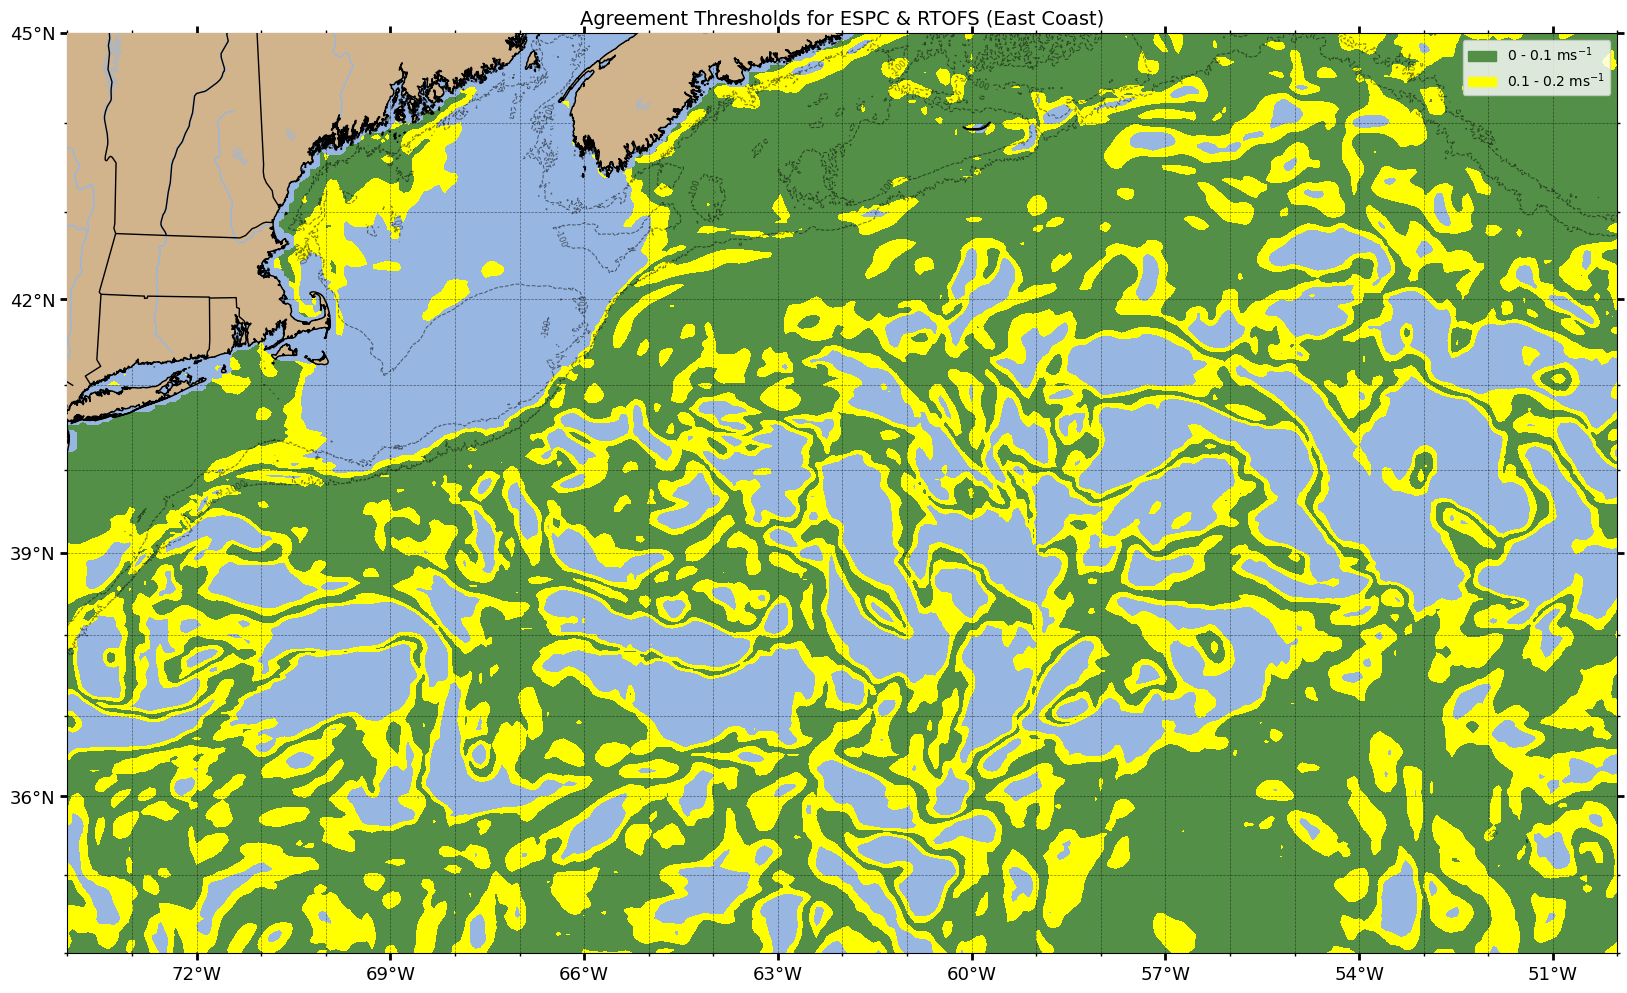

In [ ]:
import matplotlib.colors as mcolors

abs_diff = np.abs(simple_diff_23.magnitude)
abs_diff.attrs["models"] = simple_diff_23.attrs["models"]

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection": ccrs.Mercator()})
cplt.create(cplt_extent, gridlines=True, ax=ax, proj=ccrs.Mercator(), bathymetry=True)

# Define agreement thresholds and colors
mags = [0, 0.1, 0.2]
colors = ["#538f46", "yellow"]  # Corresponding colors for each range

# Ensure max_diff is properly considered
max_diff = np.nanmax(abs_diff)

# Create a colormap with BoundaryNorm for proper level-color mapping
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(mags, cmap.N)  # Ensures correct color assignment

# Plot the agreement regions using contourf
contourf = ax.contourf(
    abs_diff.lon,
    abs_diff.lat,
    abs_diff,
    levels=mags,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
)

# Create a legend
patches = [
    mpatches.Patch(color=colors[i], label=rf"{mags[i]} - {mags[i+1]} $\mathregular{{ms^{{-1}}}}$")
    for i in range(len(colors))
]

legend = ax.legend(handles=patches)
legend.set_zorder(100)

plt.title(f"Agreement Thresholds for {abs_diff.attrs['models']}", fontsize=14);

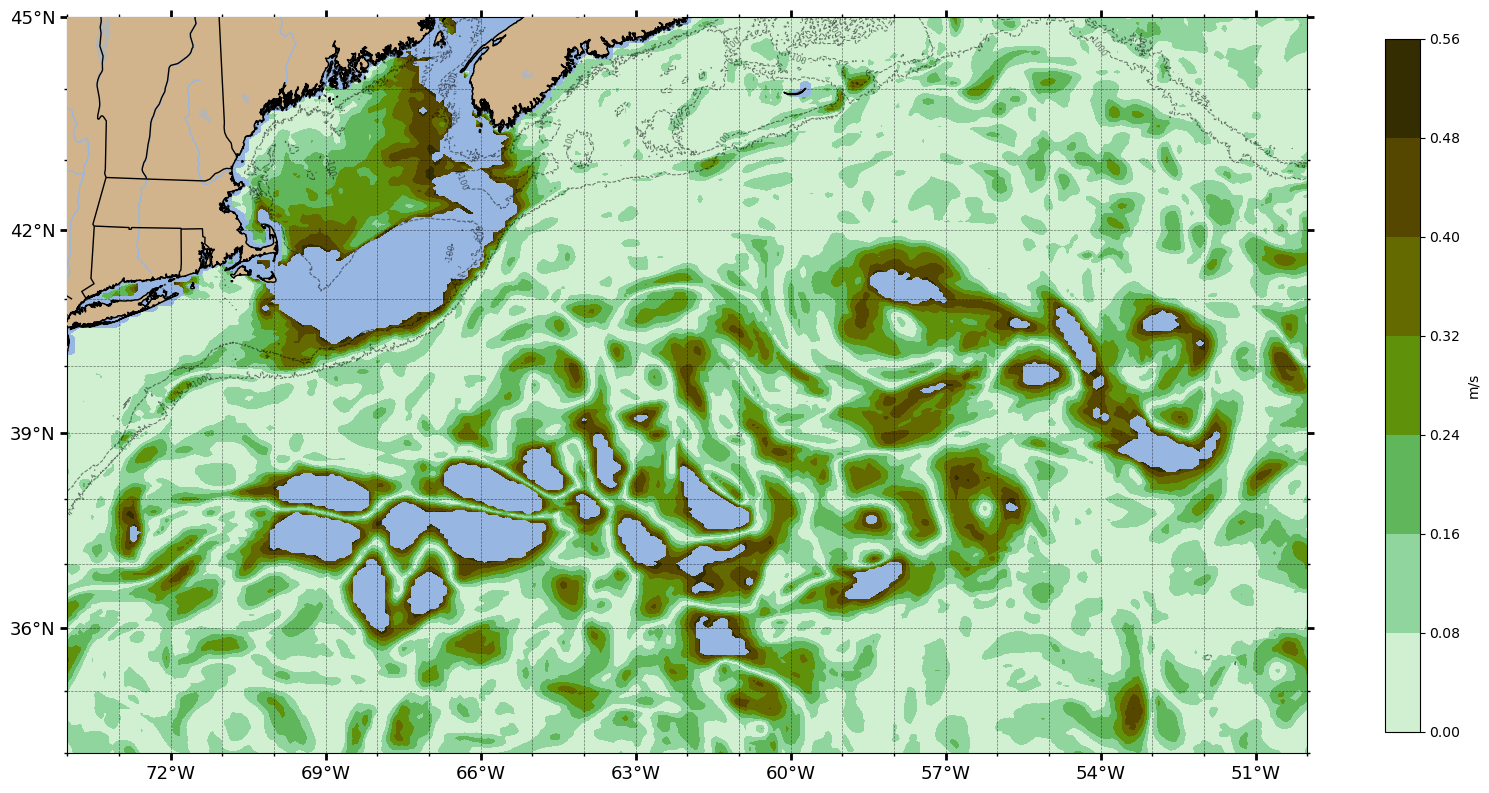

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection":ccrs.Mercator()})
cplt.create(cplt_extent, gridlines=True, ax=ax, proj=ccrs.Mercator(), bathymetry=True)
contourf = ax.contourf(simple_diff_12_masked_abs.lon, simple_diff_12_masked_abs.lat, simple_diff_12_masked_abs.magnitude, cmap=cmo.speed_i_r, transform=projection)
cbar = plt.colorbar(contourf, label="m/s", shrink=0.45)